# Introduction

This project is an analysis of Nike Amazon reviews. The goal is to create topic models for two different datasets: low star reviews (1 or 2 stars) which we will be called "bad" reviews for the rest of the analysis, and high star reviews (4 or 5 stars), which we will be called "good" reviews. From these topic models we will extract insights that will hopefully show ways that the products with bad reviews could be improved into products with good reviews.

The overall structure of the project:
1. Extract the Nike ASINs
2. Extract the relevant reviews for Nike ASINs
3. Split into bad and good review datasets
4. Create corpus for bad reviews and for good reviews
5. Create topic models
6. Evaluate topic models to tune number of topics, eta, and alpha
7. Present insights from models

We will start by mounting our Google Drive where the data is.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#uninstall a couple packages that cause issues
!pip uninstall -y numba
!pip uninstall -y tensorflow

Found existing installation: numba 0.57.1
Uninstalling numba-0.57.1:
  Successfully uninstalled numba-0.57.1
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0


In [ ]:
#install needed packages
!pip install lda
!pip install "tmtoolkit[recommended]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.9/320.9 kB 6.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for lda: filename=lda-2.0.0-cp310-cp310-linux_x86_64.whl size=360405 sha256=6c4db87338ddfc5acc376bdb46ee74e2b58a83fe52df81960307993bbe63088c
  Stored in directory: /root/.cache/pip/wheels/9d/32/fa/07fdf278a0b24269ce4d0be3d642c28dd0e888a4c5f2031279
Successfully built lda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 57.0 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19545 sha256=84eaffd3bdd1bbcfeb745504d30531a973a86041960720a8f62052c03be575bf
  Stored in directory: /root/.cache/pip/wheels/e6/c5/26/0d27e07d5

In [ ]:
#import all neccessary packages
import gzip
import itertools
import json
import csv
import matplotlib.pyplot as plt
import logging
import warnings
import numpy as np

from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import dtm, to_uppercase, remove_common_tokens, remove_uncommon_tokens
from tmtoolkit.corpus import vocabulary
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words, ldamodel_top_topic_docs
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.corpus import remove_punctuation
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

from tmtoolkit.topicmod import tm_lda

from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results

from tmtoolkit.corpus.visualize import plot_doc_lengths_hist, plot_doc_frequencies_hist

In [ ]:
# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False
warnings.filterwarnings('ignore')

In [ ]:
mypath = "/content/drive/MyDrive/Marketing_Analytics/2_Unsupervised_Learning/Final"

## Extract The Nike ASINs
We will start by going through the meta data to find all the ASINs (an unique Amazon product identifier) that are for Nike products. The metadata has a place for "brand", but it is blank often. The most reliable way will be to look through the categories the product is listed under. We will flatten the category groupings to a list and then check if one of the categories is "nike".

In [ ]:
#initialize variable
asins = []

#open gz file
with gzip.open("drive/MyDrive/meta_Clothing_Shoes_and_Jewelry.jsonl.gz") as products:
#with open("/kaggle/input/class-amazon-review-data/meta_Clothing_Shoes_and_Jewelry.jsonl/meta_Clothing_Shoes_and_Jewelry.jsonl") as products:
    #loop through all predicts
    for product in products:
        data = json.loads(product)
        categories = []
        #flatten categories to check if Nike is there
        for category_list in data.get("categories", []):
            _catlist = []
            for item in category_list:
                _catlist.append(item.lower())
            categories += _catlist
        #if Nike is there, then add asins to variable
        if "nike" in categories:
            asins.append(data["asin"])

In [ ]:
len(asins)

8327

There are 8,327 Nike ASINs in the dataset! This is a great start, but now we need to gather the actual reviews that belong to these ASINs.

## Extract the relevant reviews
We are going to extract all reviews on Nike asins that are good reviews into one dataset and bad reviews into another dataset. We will ignore the 3 star reviews since they are a netural rating.

To do this, we will go through every rating in the dataset, check if the asin is in our asins variable, if it is we will check if the star rating was less than 3 or greater than 3, then lastly we will check to make sure the character count is greater than 5 before adding it to our list of reviews.

In [ ]:
top_asins = []
top_reviews = []
bottom_asins = []
bottom_reviews = []

with gzip.open("drive/MyDrive/reviews_Clothing_Shoes_and_Jewelry.json.gz") as reviews:
#with open("/kaggle/input/class-amazon-review-data/reviews_Clothing_Shoes_and_Jewelry.json/reviews_Clothing_Shoes_and_Jewelry.json") as reviews:
    for i, review in enumerate(reviews):
        review = json.loads(review)

        #_id = "%s.%s" % (review["asin"], review["reviewerID"])
        #if asin is a nike asin...
        if review['asin'] in asins:
            #check if star rating greater than 3 and text characters > 5
            #if so, add to top variables
            if review['overall'] > 3:
                if len(review['reviewText']) > 5:
                  #print(review)
                  top_reviews.append(review['reviewText'])
                  top_asins.append(review['asin'])
            #check if star rating less than 3 and text characters > 5
            #if so, add to bottom variables
            elif review['overall'] < 3:
                if len(review['reviewText']) > 5:
                  #print(review)
                  bottom_reviews.append(review['reviewText'])
                  bottom_asins.append(review['asin'])

In [ ]:
print(len(top_reviews))
print(len(top_asins))
print(len(bottom_reviews))
print(len(bottom_asins))

17637
17637
2265
2265


The reviews and asins variable are equal, which is good! There are many more good reviews then bad reviews. This is a good thing for Nike! Hopefully we will still be able to come up with good information from our topic modeling for the bad reviews.

We will save the asins and review texts into a csv in case we want to come back to it later.

In [ ]:
with open("drive/MyDrive/Final_TopReviews.csv", "w") as f:
#with open("Final_TopReviews.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(zip(top_asins, top_reviews))

In [ ]:
with open("drive/MyDrive/Final_BottomReviews.csv", "w") as f:
#with open("Final_BottomReviews.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(zip(bottom_asins, bottom_reviews))

Now we will build our corpus and clean the data. We will do the following steps:
* lemmatize
* lowecase all characters
* remove punctuation
* remove numbers
* remove empty tokens
* remove tokens less than 2
* remove stopwords

In [ ]:
def build_corpus(texts, lang="en"):
    """Corpus builder which returns a Corpus object processed on texts as language
    specified by lang (defaults to "en"):

    Should perform all of the following pre-processing functions:

     - Lemmatize the tokens
     - Convert tokens to lowercase
     - Remove punctuation
     - Remove numbers
     - Remove tokens shorter than 2 characters
    """
    # Here, we just use the index of the text as the label for the corpus item
    corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)

    lemmatize(corpus)
    to_uppercase(corpus)
    to_lowercase(corpus)
    remove_punctuation(corpus)
    #remove_chars(corpus, ['1','2','3','4','5','6','7','8','9','0'])
    filter_clean_tokens(corpus, remove_empty=True, remove_shorter_than=2,
                        remove_stopwords = True,remove_numbers= True)
    #remove_common_tokens(corpus, df_threshold=0.8)
    #remove_uncommon_tokens(corpus, df_threshold=0.03)

    return corpus

In [ ]:
top_corpus = build_corpus(top_reviews)

In [ ]:
bottom_corpus = build_corpus(bottom_reviews)

We will look the the histogram of document lengths, and histrogram of document frequencies (quantity of documents each term shows up in).

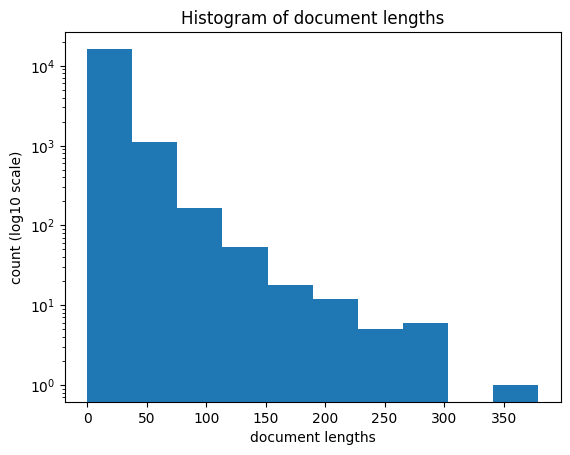

In [ ]:
#create histogram of document lengths
fig, ax = plt.subplots()
plot_doc_lengths_hist(fig, ax, top_corpus, y_log=True, bins = 10)  # use linear scale
plt.show();

This is very right-skewed (the y axis is log scaled), and most documents are pretty short. This is expected because most reviews are not super long, and we have taken out stopwords. There is a very long tail with large reviews, and sometimes the longer reviews can be the most insightful.

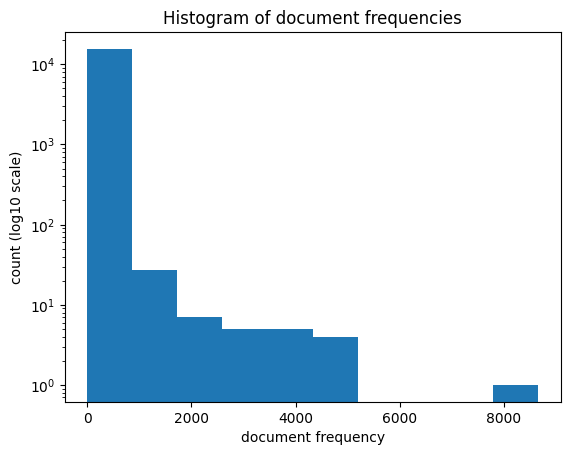

In [ ]:
#create histogram of document frequencies for terms
fig, ax = plt.subplots()
plot_doc_frequencies_hist(fig, ax, top_corpus)
plt.show();

A log-scale was used for the Y-axis because there are so many smaller document frequencies than larger ones. Most terms do not appear in more than 1000 documents. However, there are some words (maybe just 1?) that appears in ~8,000 documents. It may be interesting to figure out what that word is.

In [ ]:
#create a document-term matrix and retrieve doc labels and vocab
dtm_top, doc_labels_top, vocab_top = dtm(top_corpus, return_doc_labels=True, return_vocab=True)
dtm_bottom, doc_labels_bottom, vocab_bottom = dtm(bottom_corpus, return_doc_labels=True, return_vocab=True)

In [ ]:
#with open(mypath + "/Final_top_model.p", "wb") as modelfile:
#    save_ldamodel_to_pickle(modelfile, model, vocabulary(reviews_corpus), reviews_corpus.doc_labels, dtm=dtm(reviews_corpus))

## Topic Modeling and Tuning
We will now create the topic models and try to tune them. The parameters we will tune are n_topics (number of topics), alpha, and eta. We will set eta to a value and then trial a variety of n_topics and alpha pairs. Then we will change eta lower and trial the models again. We will change eta higher and trial the models a final time.

We will choose the parameters for a final model by looking at the cao_juan curve, and the coherence_mimno curve. We want to minimize the cao curve and maximize the coherence curve.

We will do this for both bad reviews and good reviews

### Topic modeling for good reviews

In [ ]:
#set parameters to run first topic models, with k, num_topics between 4 and 64
const_params = {'n_iter': 500,'eta': 0.1, 'random_state': 8467829  }
ks = list(range(4, 65, 4))
#print(ks)
varying_params = [dict(n_topics=k, alpha=1/k) for k in ks]

In [ ]:
#run and evaluate topic models
eval_results = tm_lda.evaluate_topic_models(dtm_top,
    varying_params,
    const_params, return_models=True)

(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

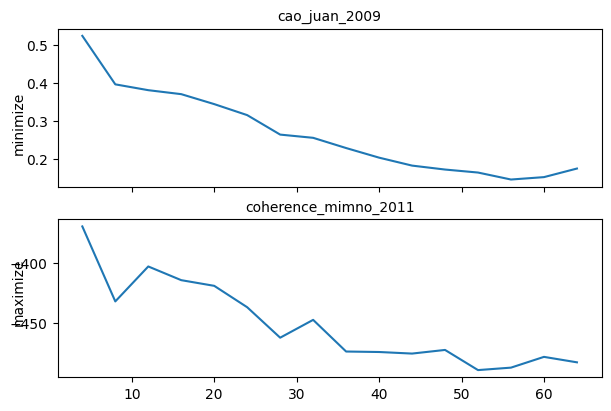

In [ ]:
# plot the results of the evaluation
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
plot_eval_results(eval_results_by_topics)

We want the cao_juan to be small and the coherence to be large. We will run another trial with a smaller eta to see if we can get better results.

(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

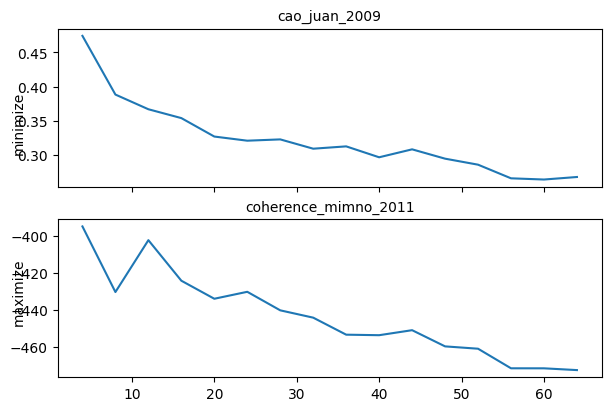

In [ ]:
#change eta to lower and try again
const_params = {'n_iter': 500,'eta': 0.01, 'random_state': 8467829  }
eval_results2 = tm_lda.evaluate_topic_models(dtm_top,varying_params,
                                             const_params, return_models=True)
eval_results_by_topics2 = results_by_parameter(eval_results2, 'n_topics')
plot_eval_results(eval_results_by_topics2)

(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

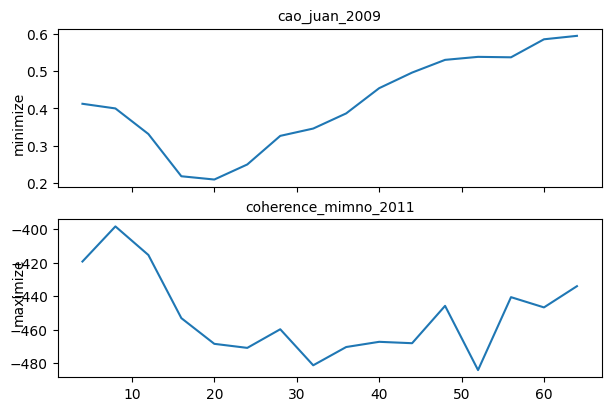

In [ ]:
const_params = {'n_iter': 500,'eta': 0.3, 'random_state': 8467829  }
eval_results3 = tm_lda.evaluate_topic_models(dtm_top,varying_params,
                                const_params, return_models=True)
eval_results_by_topics3 = results_by_parameter(eval_results3, 'n_topics')
plot_eval_results(eval_results_by_topics3)

Although the last round of models produced a cao score around 0.2, the coherence score also decreased to around  -460. The best model looks to be when eta = 0.01, k = 12, and alpha = 1/12. It leads to the best trade-off of minimized cao_juan and maximized coherence. Below we will save this best model to a variable for use later.

In [ ]:
best_top_model = [m for k, m in eval_results_by_topics2 if k == 12][0]['model']

### Topic modeling for bad reviews

(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

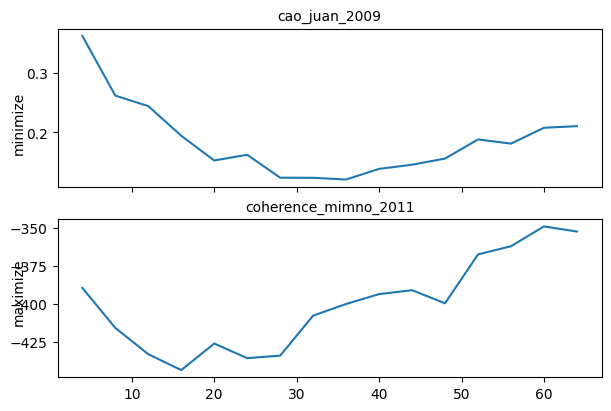

In [ ]:
const_params = {'n_iter': 500,'eta': 0.1, 'random_state': 8467829  }
bottom_eval_results1 = tm_lda.evaluate_topic_models(dtm_bottom,
    varying_params,const_params, return_models=True)
bottom_eval_results_by_topics1 = results_by_parameter(bottom_eval_results1, 'n_topics')
plot_eval_results(bottom_eval_results_by_topics1)

(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

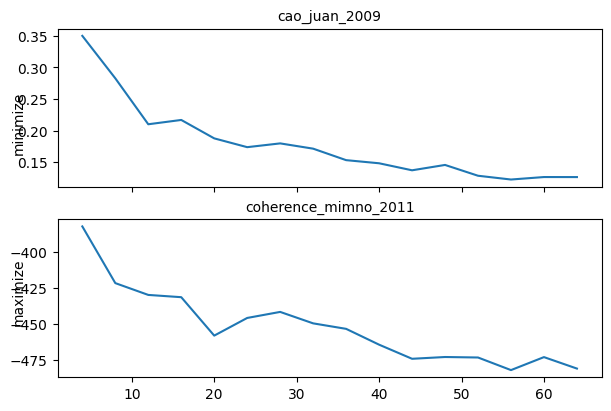

In [ ]:
const_params = {'n_iter': 500,'eta': 0.01, 'random_state': 8467829  }
bottom_eval_results2 = tm_lda.evaluate_topic_models(dtm_bottom,
    varying_params,const_params, return_models=True)
bottom_eval_results_by_topics2 = results_by_parameter(bottom_eval_results2, 'n_topics')
plot_eval_results(bottom_eval_results_by_topics2)

(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

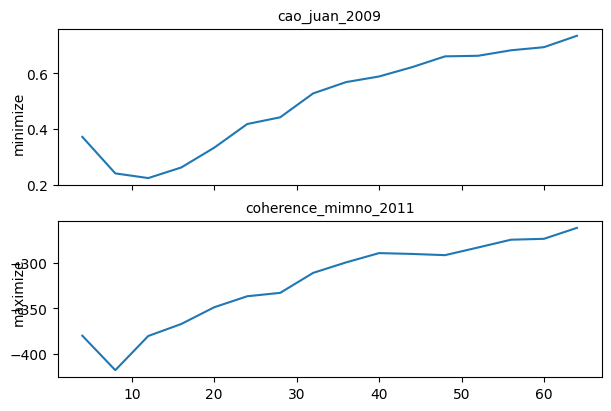

In [ ]:
const_params = {'n_iter': 500,'eta': 0.3, 'random_state': 8467829  }
bottom_eval_results3 = tm_lda.evaluate_topic_models(dtm_bottom,
    varying_params,const_params,  return_models=True)
bottom_eval_results_by_topics3 = results_by_parameter(bottom_eval_results3, 'n_topics')
plot_eval_results(bottom_eval_results_by_topics3)

The best model looks to be when eta = 0.3, k = 12, and alpha = 1/12. It leads to the best trade-off of minimized cao_juan and maximized coherence. Below we will save this best model to a variable for use later.

In [ ]:
best_bottom_model = [m for k, m in bottom_eval_results_by_topics3 if k == 12][0]['model']

# Classify reviews into the topics
The top 5 words per topic will be shown and then topic labels will be created for each topic. Then we will manually examine the top 10 reviews that are most probable to belong to that topic. From this examination process, topic descriptions will be created.

In [ ]:
#show top 5 topic words
print_ldamodel_topic_words(best_bottom_model.topic_word_, vocab_bottom, top_n=5)

topic_1
> #1. watch (0.073598)
> #2. nike (0.018846)
> #3. band (0.014935)
> #4. buy (0.013033)
> #5. work (0.011341)
topic_2
> #1. size (0.060803)
> #2. shoe (0.040779)
> #3. fit (0.027868)
> #4. small (0.027516)
> #5. foot (0.022862)
topic_3
> #1. mom (0.002554)
> #2. fast (0.002554)
> #3. truly (0.002148)
> #4. pretty (0.002148)
> #5. woman (0.001743)
topic_4
> #1. shoe (0.073716)
> #2. nike (0.023008)
> #3. wear (0.021019)
> #4. buy (0.019076)
> #5. foot (0.016577)
topic_5
> #1. shoe (0.033391)
> #2. nike (0.021263)
> #3. look (0.019022)
> #4. color (0.017704)
> #5. like (0.016913)
topic_6
> #1. altimeter (0.004533)
> #2. sensor (0.003329)
> #3. hat (0.002928)
> #4. head (0.002928)
> #5. live (0.002928)
topic_7
> #1. order (0.024405)
> #2. return (0.024293)
> #3. shoe (0.022833)
> #4. size (0.016094)
> #5. send (0.013960)
topic_8
> #1. sandal (0.022163)
> #2. flip (0.005170)
> #3. wash (0.005170)
> #4. slip (0.004809)
> #5. strap (0.004809)
topic_9
> #1. zumba (0.006067)
> #2. sadl

In [ ]:
# create topic labels
doc_lengths_bottom = doc_lengths(dtm_bottom)
bottom_topic_labels = generate_topic_labels_from_top_words(
    best_bottom_model.topic_word_,
    best_bottom_model.doc_topic_,
    doc_lengths_bottom,
    np.array(vocab_bottom),
    lambda_=0.8
)
bottom_topic_labels

array(['1_watch_band', '2_size_small', '3_mom_fast', '4_shoe_nike',
       '5_shoe_color', '6_altimeter_sensor', '7_order_return',
       '8_sandal_flip', '9_zumba_dance', '10_cleat_strike', '11_que_el',
       '12_bag_pant'], dtype='<U18')

In [ ]:
#classify all documents and rank by most probable document for each topic
documentclassifications = ldamodel_top_topic_docs(best_bottom_model.doc_topic_, doc_labels_bottom, top_n=10,
                                                  topic_labels=bottom_topic_labels)

In [ ]:
#show the classification table with the top 10 documents for each topic
documentclassifications

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
1_watch_band,239 (0.9943),3 (0.9897),359 (0.9809),361 (0.9805),147 (0.9796),450 (0.9792),374 (0.9792),50 (0.9792),56 (0.9782),72 (0.9782)
2_size_small,1698 (0.9898),995 (0.9771),1028 (0.9722),2110 (0.9714),748 (0.9704),767 (0.9694),1233 (0.9684),19 (0.9684),1170 (0.966),1443 (0.9633)
3_mom_fast,1504 (0.7403),2233 (0.6944),2185 (0.5743),1614 (0.4537),2245 (0.4236),1516 (0.4132),846 (0.3514),2188 (0.3508),518 (0.3403),2133 (0.3389)
4_shoe_nike,1247 (0.9908),877 (0.9902),1373 (0.9881),1409 (0.9874),1736 (0.9863),1129 (0.9852),1764 (0.9847),2251 (0.9839),2112 (0.982),2212 (0.9813)
5_shoe_color,1389 (0.9765),1186 (0.9745),372 (0.9738),674 (0.9718),1523 (0.9717),1058 (0.9673),1072 (0.9618),1000 (0.9601),231 (0.9563),1068 (0.9518)
6_altimeter_sensor,1489 (0.753),2178 (0.5417),200 (0.473),2186 (0.465),693 (0.4537),1502 (0.4149),1317 (0.4083),81 (0.3863),1581 (0.3862),667 (0.3802)
7_order_return,1180 (0.9845),1122 (0.9684),460 (0.9633),1306 (0.9633),313 (0.9601),1802 (0.9583),577 (0.9563),414 (0.955),1606 (0.9518),1696 (0.9491)
8_sandal_flip,1618 (0.9295),1730 (0.7569),866 (0.6083),614 (0.5947),594 (0.5754),1336 (0.5734),845 (0.5677),1342 (0.5648),1521 (0.5602),439 (0.5451)
9_zumba_dance,1494 (0.8465),1501 (0.553),1144 (0.5417),1304 (0.5188),1840 (0.4083),1284 (0.4013),920 (0.3546),463 (0.3514),1435 (0.3403),1047 (0.3389)


In [ ]:
#look at reviews for each topic and come with insights
#topic will be manually changed from 0 through 11 to look through
#all topics
topic = 0
for i in range(10):
    print(str(i) + ". " + str(bottom_asins[int(documentclassifications.iloc[topic][i].split()[0])]) +
          " - " + bottom_reviews[int(documentclassifications.iloc[topic][i].split()[0])] + "\n")

0. B000QRMTHE - I bought this watch a while ago, not from this seller.This review is on the completely black model.This watch had the features i wanted and had it worked as expected, i would have been really happy.Complaints:- upon set up, initial setting of the time etc. the analog hands were reluctant to start ticking. this is after i synchronised the analog time to the digital time (this has to be done manually). after messing with the analog set button for a while, it decided to start moving again. this would happen from time to time when setting the analog time. after about 6 months of use, the analog hands ceased to be reliable and eventually stopped, leaving me with only digital times.- this watch is supposed to be water proof and i hoped to be able to have this watch on all the time in all my various activities including those where the watch would be immersed in water. after my first shower, i found condensate under the glass. i opened the back and allowed this to evaporate, b

The code block above lets us look through 10 samples in a topic to get an understanding of what the topic is about. Below, we list the descriptions we hand crafted for each topic.

## Bad Review Topics Descriptions

* Topic 1 - Wide variety of watches with poor quality (broken straps, broken buttons, screen issues)
* Topic 2 - Some Nike socks and shoes are too small/tight and uncomfortable
* Topic 3 - Consumers claim received fake products and some random/fake reviews
* Topic 4 - Variety of shoes have poor durability
* Topic 5 - Received different color than images, and some fake products
* Topic 6 - A bunch of different reviews: fake product, fake reviews, real complaints
* Topic 7 - Issues with size of shoes and with returning and refunds
* Topic 8 - Products smell and sandals uncomfortable
* Topic 9 - Vaierty of issues: mostly uncomfortable glasses and shoes
* Topic 10 - Uncomfortable shoes and cleats
* Topic 11 - Spanish reviews
* Topic 12 - Various bags have poor quality/design


We will now do the same process for the good review topics:

In [ ]:
#show top 5 words for each topic
print_ldamodel_topic_words(best_top_model.topic_word_, vocab_top, top_n=5)

topic_1
> #1. shoe (0.037126)
> #2. buy (0.015615)
> #3. find (0.014363)
> #4. store (0.013243)
> #5. price (0.012387)
topic_2
> #1. muy (0.030583)
> #2. de (0.029247)
> #3. la (0.023903)
> #4. el (0.023903)
> #5. en (0.018113)
topic_3
> #1. love (0.069482)
> #2. son (0.043060)
> #3. buy (0.040161)
> #4. shoe (0.039108)
> #5. great (0.025369)
topic_4
> #1. shoe (0.047604)
> #2. foot (0.027616)
> #3. good (0.025009)
> #4. like (0.019183)
> #5. wear (0.016576)
topic_5
> #1. size (0.095423)
> #2. shoe (0.056354)
> #3. fit (0.042257)
> #4. order (0.030264)
> #5. small (0.029212)
topic_6
> #1. sock (0.030633)
> #2. bag (0.026197)
> #3. fit (0.023489)
> #4. great (0.022275)
> #5. good (0.016484)
topic_7
> #1. shoe (0.046861)
> #2. great (0.042431)
> #3. good (0.033894)
> #4. product (0.031697)
> #5. fit (0.030941)
topic_8
> #1. watch (0.068195)
> #2. time (0.021632)
> #3. easy (0.014265)
> #4. like (0.013708)
> #5. look (0.013408)
topic_9
> #1. shoe (0.090906)
> #2. great (0.053407)
> #3. co

In [ ]:
#create topic labels
doc_lengths_top = doc_lengths(dtm_top)
top_topic_labels = generate_topic_labels_from_top_words(
    best_top_model.topic_word_,
    best_top_model.doc_topic_,
    doc_lengths_top,
    np.array(vocab_top),
    lambda_=0.8
)
top_topic_labels

array(['1_shoe_store', '2_muy_de', '3_love_son', '4_shoe_foot',
       '5_size_shoe', '6_sock_bag', '7_product_great', '8_watch_time',
       '9_shoe_great', '10_pair_wear', '11_shoe_run', '12_color_shoe'],
      dtype='<U15')

In [ ]:
#classify all documents and rank by most probable document for each topic
top_documentclassifications = ldamodel_top_topic_docs(best_top_model.doc_topic_, doc_labels_top, top_n=10,
                                                  topic_labels=top_topic_labels)

In [ ]:
#show the classifications
top_documentclassifications

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
1_shoe_store,10984 (0.9852),9594 (0.9722),14692 (0.9583),17085 (0.9554),12050 (0.9468),16806 (0.9389),15201 (0.9389),14484 (0.9295),11871 (0.9295),11088 (0.929)
2_muy_de,5530 (0.9865),900 (0.9861),8186 (0.9857),8846 (0.9854),458 (0.9842),1059 (0.9817),6393 (0.9805),3495 (0.9792),8056 (0.9792),5795 (0.9782)
3_love_son,16035 (0.9491),3718 (0.9491),4620 (0.9427),9032 (0.9427),4866 (0.9427),2108 (0.9427),14057 (0.9389),12093 (0.9389),872 (0.9389),15532 (0.9389)
4_shoe_foot,10713 (0.981),7965 (0.9787),8930 (0.9714),16281 (0.9673),8070 (0.9563),3809 (0.9491),9461 (0.9461),11506 (0.9436),14489 (0.9427),6079 (0.9427)
5_size_shoe,2473 (0.9633),8207 (0.9601),5148 (0.9601),1743 (0.9583),15643 (0.9518),3430 (0.9518),5072 (0.9518),17230 (0.9518),6490 (0.9491),1967 (0.9461)
6_sock_bag,12497 (0.9673),7285 (0.9583),13737 (0.9518),7071 (0.9518),7141 (0.9491),7249 (0.9461),17487 (0.9427),6652 (0.9427),3527 (0.9389),7264 (0.9389)
7_product_great,1277 (0.9618),2378 (0.9583),3442 (0.9563),7620 (0.9518),13931 (0.9491),16296 (0.9491),8175 (0.9461),4825 (0.9427),8408 (0.9427),12575 (0.9427)
8_watch_time,347 (0.966),1849 (0.9647),1672 (0.9633),331 (0.9601),1354 (0.9601),625 (0.9601),554 (0.9574),1851 (0.9533),612 (0.9518),657 (0.9518)
9_shoe_great,10919 (0.9491),15923 (0.9461),8006 (0.9461),10189 (0.9427),4653 (0.9427),12707 (0.9427),10520 (0.9427),2676 (0.9427),15918 (0.9389),9966 (0.9389)


In [ ]:
#look at reviews for each topic and come with insights
#topic will be manually changed from 0 through 11 to look through
#all topics
topic = 11
for i in range(10):
    print(str(i) + ". " + str(top_asins[int(top_documentclassifications.iloc[topic][i].split()[0])]) +
          " - " + top_reviews[int(top_documentclassifications.iloc[topic][i].split()[0])] + "\n")

0. B0084YNQQO - Im a bonafide sneakerhead.  When I saw these, I had to have them.  I wanted teh TLX in all red, but it appears it was strictly a European release.Anyhow the blue are fantastic as well as the silver and black accents.  Mostly looking forward to wearing them in summer with khaki shorts as I dont like blue shoes with blue jeans.

1. B00K00NS68 - I went from an Air Max shoe to these because the air popped in the air max shoe.  Can't believe how comfortable and how well these fit!  Kind of hard to keep clean but they do clean up good.  Seem to match everything!  Very cool, comfortable shoe!

2. B005OB5384 - these shoes look absolutely amazing. the black is dark and super rich and the red is a real deep red so the colors together look unreal. BUY THESE SHOES you will not regret it

3. B00D8QN4SS - These Nike's fit great, however the shoes I received were not the same color as the original photo. The original photo was black, blue and orange, but the sneakers I received were g

The code block above lets us look through 10 samples in a topic to get an understanding of what the topic is about. Below, we list the descriptions we hand crafted for each topic.

## Good Review Topic Descriptions

* Topic 1 - Happy to find authentic shoes online
* Topic 2 - Spanish reviews
* Topic 3 - Shoes purchased for younger boys/girls who loved them. Christmas/birthday gifts
* Topic 4 - Great fitting and comfortable shoes
* Topic 5 - People have to order larger sizes, but stretch and then are comfortable
* Topic 6 - Quality bags, lots of space
* Topic 7 - Consumers pleased to order online and receive on time
* Topic 8 - The watches are easy to use
* Topic 9 - Shoes look good, fit well, and are lightweight/comfortable
* Topic 10 - Shoes/sandals are loved and comfortable. Consumers already own a second pair or plan to buy 2nd pair in future
* Topic 11 - Running shoes have great cushioning, very comfortable
* Topic 12 - Love the colors and style of shoes

# Insights
* Many bad reviews were for receiving fake products, and topic 1 for good reviews was all about being extremely happy about finding authentic Nike shoes online. Should leverage this and make it easier for people to shop and confirm the authenticity of Nike shoes (and other products) online.
* The watches had many bad reviews about broken straps and buttons, but also many good reviews about ease to use. Should discuss with R&D to make strap more durable or replaceable.
* Many bad reviews topics were about uncomfortable or wrong sizing for socks or shoes. Should offer free returns/exchanges to all online customers to encourage more people to buy from Nike with no risk of incorrect sizing. This may keep customers from going to another brand that offers this.
* Topic 3 of good reviews were about shoes purchased mostly for sons/daughters for Christmas or bithdays. Should use this in marketing to highlight how amazing of a gift Nike shoes can be. And increase marketing spend close to Christmas for younger audiences.
* Topic 7 was consumers that were super pleased to be able to order shows online (that they might not have been able to find in stores) and receive on time/early. We should highlight in marketing and on websites this fact -> fast shipping, satisifaction guaranteed.
* Topic 10 were consumers that loved Nike shoes/sandals so much that they purchased or planned to purchase another pair. These consumers LOVE Nike and  should be able to get them to sign up for a Nike newsletter (or similar) and then be able to send them yearly coupons to show appreciation for the love of Nike.
* Can also use topic 10 for marketing to show people are so impressed with product, they buy it multiple times.
* People love the look and design of certain Nike shoes. Should highlight this in all visual marketing
* Did not see any reviews on Nike shorts, shirts, or underwear. Are they not sold on Amazon? Should we begin to sell on Amazon? If they are, maybe increase advertising on them to improve visibility.
* People were pleased with the pricing of products compared to in retail stores. There seemed to be a discount on Amazon, and consumers took notice. Could emphasize this more with advertising.
* The reviews that mentioned the Nike "swoosh" were positive, and liked on the product. Nike should continue to have the swoosh be a part of their future products.
* Topic 8 for bad reviews was for smelly sandals and shoes. Most of them said when they got wet, the product smelled really bad. Should investigate...is it a material issue?
* No reviews mentioned endorsed athletes. Nike pays so much for endorsements it is surprising that no one says they want to look like their favorite athlete. One potential reason: subconsiously people see their favorite athletes wearing a brand, but then when they buy and review product they are just thinking about the quality and feel of the actual product.

# Summary
In this project we segmented the data into Nike bad reviews (1 or 2 stars) and Nike good reviews (4 or 5 stars). The 3 star reviews are seen as neutral and ignored for this analysis. After this, the bad and good reviews were used to create a corpus for each of them. This process cleaned the text fairly aggressively and involved lemmatizing, lowercasing, removing punctuation, removing numbers, and removing stop words. This preprocess cleaning was performed because it leads to better results and words with more meaning being linked to the topic models.

After this, we created the topic models for both good and bad reviews. We evaluated the topic models by using different values for k, alpha, and eta and choose the option with the best trade-off between minimizing cao-juan and maximizing coherence. We then used these best models to show the top 5 words for each topic, create topic labels, and then classify all the reviews. We then manually went through 10 reviews for each topic and created brief descriptions for each topic. Lastly, we extracted some insights from the topics that can be used in marketing, R&D, and strategy.

Some of the most important insights: people love the ease of buying online and Nike should do whatever they can to make this process easy and frictionless. The watches strap design is a flaw and needs to be fixed. There are many people that love the Nike brand, and they should work to get them into their ecosystem (get their email) and keep them up to date on new products and offer exclusive discounts.